In [5]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip3 install pickle5
import pickle5 as pickle
!pip3 install --upgrade pandas==1.3.4
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

from google.colab import drive
drive.mount('/content/drive')

!ls drive/'My Drive'

drive_path = 'drive/My Drive/'
drive_path = 'drive/MyDrive/Deep Learning/Lira'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'02450_Book - Copy.pdf'
 02450_Book.pdf
 02450Toolbox_Python
'Alfa Laval'
 Art
 aswinanilvarkey-cv.pdf
 Badminton
'Colab Notebooks'
 Coronapas.pdf
 CV
'Deep Learning'
 Denmark
 Documents
 DTU
'Event Feedback.gform'
 Expenditure.gsheet
'Flight Ticket.pdf'
'Garden Fresh'
 Germany
 LCD2
 Marksheet-1.pdf
'NDA Aswin.gdoc'
'NDA Aswin.pdf'
 photo
'QNet Ltd __ Receipt.pdf'
 R
'Rental Agreement.tif'
 Smartphone
'SRM Institute of Science and Technology__SRM Feekart.pdf'
 TN_KL-CHN_DF_0209_264448.pdf
'Untitled spreadsheet.gsheet'
'Vestas Badminton.gform'
'Vestas Badminton (Responses).gsheet'
'Vestas Badminton Weekly Session.gform'
'Vestas Badminton Weekly Session (Responses).gsheet'
 VID_52190412_020837_341.mp4
 Visa
 VN20200831_173740.mp4


In [6]:
with open(drive_path+'/Copy of dataset_smol_boi.pickle', 'rb') as f:
    data_org = pickle.load(f)

AttributeError: ignored

In [3]:

# def moving_average(x, w):
#     return np.convolve(x, np.ones(w), 'valid') / w

# train_dataset = moving_average(data['GM.acc.xyz.z'][8],10)

# test_dataset = moving_average(data['GM.acc.xyz.z'][1615],10)

train_dataset = [[],[]]
test_dataset = [[],[]]
iri_mean = []
data = data_org['train']
data = data.sort_values(by=['IRI_mean'])

for i in range(int(len(data['IRI_Sequence']))):
    mean = np.mean(data['IRI_Sequence'].iloc[i])
    iri_mean.append(mean)
    if mean <4:
        train_dataset[0].append(mean)
        train_dataset[1].append(data['z_smooth'].iloc[i])
    elif mean > 6:
        test_dataset[0].append(mean)
        test_dataset[1].append(data['z_smooth'].iloc[i])

train_np = np.asarray(train_dataset,dtype=object).T
test_np = np.asarray(test_dataset,dtype=object).T
df_train = pd.DataFrame(np.asarray(train_dataset,dtype=object).T,columns=['iri','z'])

num_batches_train = len(df_train)

In [8]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len+1, n_features

print('train dataset',train_np.shape)
lstm_df_train = pd.DataFrame([np.append(*row) for row in train_np])
lstm_df_train = lstm_df_train.drop(lstm_df_train.columns[1], axis=1)
print(lstm_df_train.shape)
lstm_df_train = lstm_df_train.loc[:50,1:]
train_dataset, seq_len, n_features = create_dataset(lstm_df_train)
print('train dataset',lstm_df_train.shape)
lstm_df_test = pd.DataFrame([np.append(*row) for row in test_np])
lstm_df_test = lstm_df_test.drop(lstm_df_test.columns[1], axis=1)
lstm_df_test = lstm_df_test.loc[:40,1:]
print(lstm_df_test.shape)
test_dataset, seq_len_test, n_features_test = create_dataset(lstm_df_test)



train dataset (979, 2)
(979, 3065)
train dataset (51, 3064)
(41, 3064)


In [39]:
# working model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.seq_len = seq_len
        self.lstm1 = nn.LSTM(1, 100, 1, batch_first = True)
        self.lstm2 = nn.LSTM(100, 50, 1, batch_first = True)
        self.lstm3 = nn.LSTM(50, 100, 1, batch_first = True)
        
        self.l_out = nn.Linear(in_features=100,
                            out_features=1,
                            bias=False)
        
    def forward(self, x):
        print(x.size())
        x, (h, _) = self.lstm1(x)
        print(x.size())
        x, (h, _) = self.lstm2(x)
        x, (h, _) = self.lstm3(x)
        
        x = x.view(-1, self.lstm3.hidden_size)        
        x = self.l_out(x)
        
        return x

model = Autoencoder()

model = model.to(device)
print(model)


Autoencoder(
  (lstm1): LSTM(1, 100, batch_first=True)
  (lstm2): LSTM(100, 50, batch_first=True)
  (lstm3): LSTM(50, 100, batch_first=True)
  (l_out): Linear(in_features=100, out_features=1, bias=False)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 3065, 1])) that is different to the input size (torch.Size([3065, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1: train loss 0.0720793753862381
Epoch 2: train loss 0.07086361199617386
Epoch 3: train loss 0.06605436652898788
Epoch 4: train loss 0.06368494033813477
Epoch 5: train loss 0.061831165105104446
Epoch 6: train loss 0.059013158082962036
Epoch 7: train loss 0.05630775913596153
Epoch 8: train loss 0.0546044185757637
Epoch 9: train loss 0.05303608998656273
Epoch 10: train loss 0.051111675798892975
Epoch 11: train loss 0.04921730235219002
Epoch 12: train loss 0.047753676772117615
Epoch 13: train loss 0.04662046581506729
Epoch 14: train loss 0.04531072825193405
Epoch 15: train loss 0.04382739216089249
Epoch 16: train loss 0.0425589382648468
Epoch 17: train loss 0.0415167361497879
Epoch 18: train loss 0.040439192205667496
Epoch 19: train loss 0.03921975940465927
Epoch 20: train loss 0.03800659626722336
Epoch 21: train loss 0.036977168172597885
Epoch 22: train loss 0.036010950803756714
Epoch 23: train loss 0.03492778539657593
Epoch 24: train loss 0.033836524933576584
Epoch 25: train loss 

Text(0.5, 1.0, 'LSTM Autoencoder')

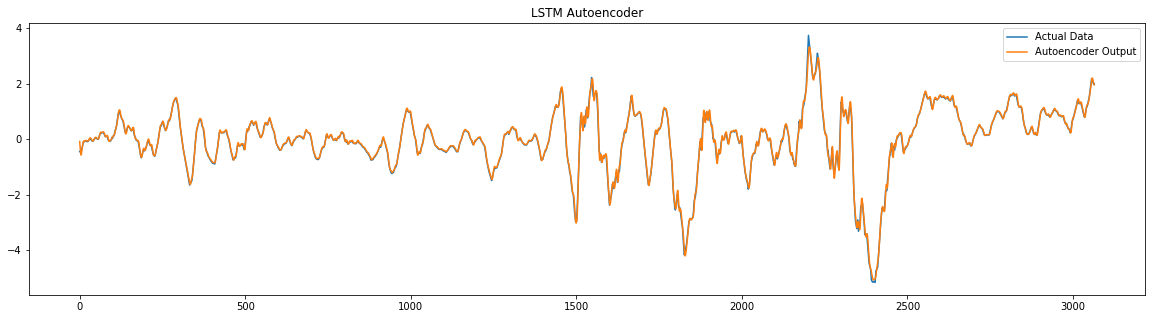

In [11]:
# LSTM 100m
        
def train_model(model, train_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  best_loss = 10000.0
  output = []
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []      
    optimizer.zero_grad()
    seq_true = torch.Tensor(train_np[0,1]).cuda()
    seq_true = seq_true.to(device)
    seq_true = seq_true.reshape((1, seq_len, 1))
    seq_pred = model(seq_true)
    loss = criterion(seq_pred, seq_true)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
    if(epoch == n_epochs):
      output.append(seq_pred.cpu().detach().numpy())
  return model.eval(), history, output

model, history, pred = train_model(
  model,
  train_dataset,
  n_epochs=100
)


plt.figure(figsize=[20,5])
plt.plot(train_np[0,1][:])
plt.plot(pred[0])
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

In [9]:
# LSTM all 100m
def train_model(model, train_dataset, n_epochs):
  model_out = np.asarray([])
  model_in = np.asarray([])
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  #criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])
  best_loss = 10000.0
  for epoch in range(1, n_epochs + 1):
    i = 0
    model = model.train()
    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()
      seq_true = seq_true.to(device)
      seq_true = seq_true.reshape((1, seq_len, 1))
      seq_pred = model(seq_true)
      loss = criterion(seq_pred, seq_true)
      loss.backward()
      optimizer.step()
      train_losses.append(loss.item())
      if epoch == n_epochs:
        model_out = np.concatenate((model_out,np.reshape(seq_pred.cpu().detach().numpy(),(seq_len,))))
        model_in=np.concatenate((model_in,np.reshape(seq_true.cpu().numpy(),(seq_len,))))  
      i+=1
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
  return model.eval(), history, model_out, model_in

model, history, model_out, model_in = train_model(
  model,
  train_dataset,
  n_epochs=6
)


plt.figure(figsize=[20,5])
plt.plot(model_in[:1000],'r')
plt.plot(model_out[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

3064


In [1]:
# Test Dataset
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

seq_true = test_dataset[-1]
seq_true = seq_true.to(device)
seq_true1 = seq_true.reshape((1, seq_len-1, 1))
seq_pred = model(seq_true1)
loss = criterion(seq_pred, seq_true)
print(loss)

plt.figure(figsize=(20,5))
plt.plot(seq_true.cpu()[:1000],'r')
plt.plot(seq_pred.cpu().detach().numpy()[:1000],'b')
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder - Test')

NameError: ignored

In [48]:
# LSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Encoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    # print(self.seq_len, self.n_features, self.embedding_dim, self.hidden_dim)
    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)
    return hidden_n.reshape((self.n_features, self.embedding_dim,1))


class Decoder(nn.Module):
  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()
    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim, n_features)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))
    return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    print(x.size())
    x = self.encoder(x)
    print(x.size())
    x = self.decoder(x)
    return x

LEARNING_RATE = 3e-4
criterion = nn.MSELoss()   #<-- Your code here.   

BATCH_SIZE = 100
model = RecurrentAutoencoder(seq_len, n_features, 100)
model = model.to(device)
print(model)
print(device)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 200, batch_first=True)
    (rnn2): LSTM(200, 100, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(100, 100, batch_first=True)
    (rnn2): LSTM(100, 200, batch_first=True)
    (output_layer): Linear(in_features=200, out_features=1, bias=True)
  )
)
cuda


In [49]:
# LSTM 100m
        
def train_model(model, train_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
  criterion = nn.MSELoss()
  history = dict(train=[], val=[])
  best_loss = 10000.0
  output = []
  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []      
    optimizer.zero_grad()
    seq_true = torch.Tensor(train_np[0,1]).cuda()
    seq_true = seq_true.to(device)
    seq_true = seq_true.reshape((1, seq_len, 1))
    seq_pred = model(seq_true)
    loss = criterion(seq_pred, seq_true)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    history['train'].append(train_loss)
    print(f'Epoch {epoch}: train loss {train_loss}')
    if(epoch == n_epochs):
      output.append(seq_pred.cpu().detach().numpy())
  return model.eval(), history, output

model, history, pred = train_model(
  model,
  train_dataset,
  n_epochs=100
)


plt.figure(figsize=[20,5])
plt.plot(train_np[0,1][:])
plt.plot(pred[0])
plt.legend(['Actual Data','Autoencoder Output'])
plt.title('LSTM Autoencoder')

torch.Size([1, 3065, 1])
torch.Size([1, 100, 1])


RuntimeError: ignored